### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

# Loading dataset

In [ ]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-sm2c3aog
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-sm2c3aog
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 58 kB 4.3 MB/s 
     |████████████████████████████████| 376 kB 20.7 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0.dev0-py3-none-any.whl size=98008 sha256=79119d255252d04a5db39c4815dee938c289a7ff2461140149fed5659a6ff023
  Stored in directory: /tmp/pip-ephem-wheel-cache-eab6hedh/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bc35df615fc7ce60c

In [ ]:
#!pip install "opencv-python-headless<4.3"

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torchvision

In [ ]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module


from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [ ]:
#Traing dataset in gdrive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pathlib
import glob

'''
x_train_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/train"))
y_train_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/train"))
y_train_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/train"))

x_valid_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/val"))
y_valid_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/val"))
y_valid_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/val"))

'''
x_train_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/train")
y_train_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/train")
y_train_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/train")

x_valid_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/val")
y_valid_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/val")
y_valid_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/val")

x_test_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/test")
y_test_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/test")
y_test_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/test")

In [ ]:
'''
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

'''

"\nDATA_DIR = './data/CamVid/'\n\n# load repo with data if it is not exists\nif not os.path.exists(DATA_DIR):\n    print('Loading data...')\n    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')\n    print('Done!')\n\nx_train_dir = os.path.join(DATA_DIR, 'train')\ny_train_dir = os.path.join(DATA_DIR, 'trainannot')\n\nx_valid_dir = os.path.join(DATA_DIR, 'val')\ny_valid_dir = os.path.join(DATA_DIR, 'valannot')\n\nx_test_dir = os.path.join(DATA_DIR, 'test')\ny_test_dir = os.path.join(DATA_DIR, 'testannot')\n\n"

In [ ]:
SIZE_X = 224 
SIZE_Y = 224

# Dataloader and utility functions 

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

In [ ]:
from torch.utils.data import Dataset


# classes for data loading and preprocessing
class CityDataset(Dataset):
    
    CLASSES =   ['road','sidewalk','building','wall','fence','pole',
                'traffic light','traffic sign','vegetation','terrain','sky',
                'person','rider','car','truck','bus',
                'train','motorcycle','bicycle','unlabeled']
    '''
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    '''
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            transform=None, 
            preprocessing=None,
    ):
        
        lis_x = sorted(os.listdir(images_dir)) 
        lis_y = sorted(os.listdir(masks_dir))

        self.images_fps = [image for link in lis_x for image in sorted(glob.glob(os.path.join(images_dir,link)+'/*.png'))]
        self.masks_fps = [image for link in lis_y for image in sorted(glob.glob(os.path.join(masks_dir,link)+'/*.png'))]
        '''
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        '''
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.transform = transform
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        sample = {}
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, (SIZE_Y, SIZE_X))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample['image'] = image

        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))

        # extract certain classes from mask (e.g. cars)
        
        #masks = [(mask == v) for v in self.class_values ]
        masks = []
        for v in self.class_values:
            if v == 19:
                masks.append((mask == 255))
            else :
                masks.append((mask == v))

        mask = np.stack(masks, axis=-1).astype('float')
        '''
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        '''
        sample['mask'] = mask
        
        # apply augmentations
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            #sample['image'] = self.transform(image=sample['image'])["image"].to(torch.float)
            #sample['mask'] = self.transform(image=sample['mask'])["image"].to(torch.int)

        # apply preprocessing
        if self.preprocessing:
            sample['image'] = self.preprocessing(sample['image'])
            #image, mask = sample['image'], sample['mask']          
 
        t= torchvision.transforms.ToTensor()
        
        sample['image'] = t(sample['image']).to(torch.float)
        sample['mask'] = t(sample['mask']).to(torch.float)

        return sample
        
    def __len__(self):
        return len(self.images_fps)


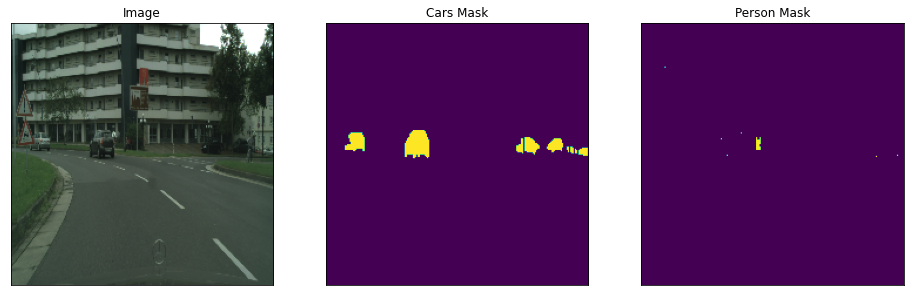

In [ ]:
# Lets look at data we have
dataset = CityDataset(x_train_dir, y_train_seg_dir, classes=['car', 'person'])

image = dataset[0]['image'] # get some sample
mask = dataset[0]['mask']

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Person_mask=mask.data.numpy().transpose(1,2,0)[..., 1],
)


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [ ]:
#!pip install -U albumentations
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


In [ ]:
#import albumentations as A
#from albumentations.pytorch import ToTensorV2

In [ ]:
#import albumentations as albu

In [ ]:
'''
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [ToTensorV2()]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [ToTensorV2()]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
'''

'\ndef round_clip_0_1(x, **kwargs):\n    return x.round().clip(0, 1)\n\n# define heavy augmentations\ndef get_training_augmentation():\n    train_transform = [ToTensorV2()]\n    return A.Compose(train_transform)\n\n\ndef get_validation_augmentation():\n    """Add paddings to make image shape divisible by 32"""\n    test_transform = [ToTensorV2()]\n    return A.Compose(test_transform)\n\ndef get_preprocessing(preprocessing_fn):\n    """Construct preprocessing transform\n    \n    Args:\n        preprocessing_fn (callbale): data normalization function \n            (can be specific for each pretrained neural network)\n    Return:\n        transform: albumentations.Compose\n    \n    """\n    \n    _transform = [\n        albu.Lambda(image=preprocessing_fn),\n        albu.Lambda(image=to_tensor, mask=to_tensor),\n    ]\n    return albu.Compose(_transform)\n'

In [ ]:
import functools

def preprocess_input(x, mean=None, std=None, input_range=None, **kwargs):

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

def get_preprocessing_fn():
    formatted_settings = {}
    formatted_settings["input_range"] = [0, 1]
    formatted_settings["mean"] = [0.485, 0.456, 0.406]
    formatted_settings["std"] = [0.229, 0.224, 0.225]
    return functools.partial(preprocess_input, **formatted_settings)

In [ ]:
# Lets look at augmented data we have
#norm  = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = CityDataset(x_train_dir, y_train_seg_dir, classes=['car', 'person'],transform=None,preprocessing=get_preprocessing_fn())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


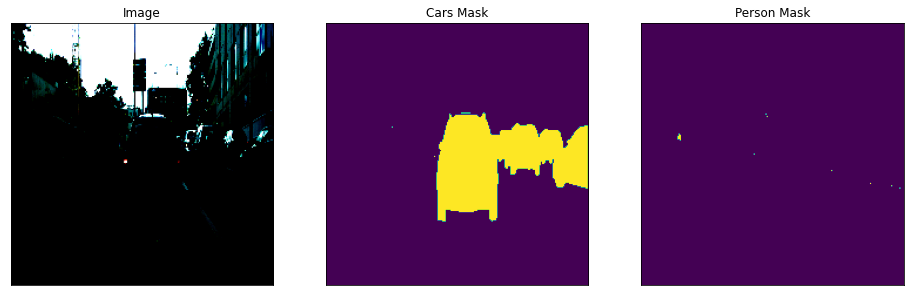

In [ ]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['mask']


visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Person_mask=mask.data.numpy().transpose(1,2,0)[..., 1],
)

# Model parameters defination.

In [ ]:
#Database.
Train_Batch_size = 8
Val_Batch_size = 8
nworkers = 4

#Optimiser and Scheduler.
epochs = 70
Lr = 0.0001

#Model Parameters

CLASSES = ['road','sidewalk','building','wall','fence','pole',
                'traffic light','traffic sign','vegetation','terrain','sky',
                'person','rider','car','truck','bus',
                'train','motorcycle','bicycle','unlabeled']

#LASSES = ['car', 'person']
Num_channels = 3

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation+ Background
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#task-type .
task_type = 'single'  # Select 'single' or 'multi'

In [ ]:
import warnings

def get_output(output):
    output = output.permute(0, 2, 3, 1)
    _, output = torch.max(output, dim=3)
    
    return output

#General Model evaluator
@torch.no_grad()
def eval_model_results(data_loader,model,n_classes=20, has_bg=False):
    n_classes = n_classes + int(has_bg)

    # Iterate
    tp = [0] * n_classes
    fp = [0] * n_classes
    fn = [0] * n_classes

    model.eval()
    for ii, sample in enumerate(data_loader):      
        inputimg, gt_masks = sample['image'].cuda(non_blocking=True), sample['mask'].cuda(non_blocking=True)
    
        output = model(inputimg)
        #output = F.softmax(output,dim=1)
           
        output = get_output(output)
        gt_masks = get_output(gt_masks)
        #print(gt_masks.shape,output.shape)

        for jj in range(int(inputimg.size()[0])):
            pred_mask = output[jj].cpu().data.numpy().squeeze()
            gt_mask = gt_masks[jj].cpu().data.numpy().squeeze()
              ##Semantic Segmentaion.               
              # resize - cv2.resize(output_task[jj], dsize=(meta['im_size'][1][jj], meta['im_size'][0][jj]), interpolation=p.TASKS.INFER_FLAGVALS[task])
      
            valid = (gt_mask != 255)

            if pred_mask.shape != gt_mask.shape:
                warnings.warn('Prediction and ground truth have different size. Resizing Prediction..')
                pred_mask = cv2.resize(pred_mask, gt_mask.shape[::-1], interpolation=cv2.INTER_NEAREST)

            # TP, FP, and FN evaluation
            for i_part in range(0, n_classes):
                tmp_gt = (gt_mask == i_part)
                tmp_pred = (pred_mask == i_part)
                tp[i_part] += np.sum(tmp_gt & tmp_pred & valid)
                fp[i_part] += np.sum(~tmp_gt & tmp_pred & valid)
                fn[i_part] += np.sum(tmp_gt & ~tmp_pred & valid)

    jac = [0] * n_classes
    for i_part in range(0, n_classes):
        jac[i_part] = float(tp[i_part]) / max(float(tp[i_part] + fp[i_part] + fn[i_part]), 1e-8)
  
    # Write results
    eval_result = dict()
    eval_result['jaccards_all_categs'] = jac
    eval_result['mIoU'] = np.mean(jac)

    return eval_result


In [ ]:
#Directory for result storage.
def mkdir_if_missing(directory):
    if not os.path.exists(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

root = os.path.join(os.getcwd(),'results')

output_dir = os.path.join(root, 'CityScapes', 'UNet', 'Seg_Baseline')
save_dir = os.path.join(output_dir, 'results')
checkpoint = os.path.join(output_dir, 'checkpoint.pth.tar')
best_model = os.path.join(output_dir, 'best_model.pth.tar')

mkdir_if_missing(output_dir)
mkdir_if_missing(save_dir)

#Training the model.

In [ ]:
#Importing resnet backbone network
backbone = torchvision.models.resnet.resnet50(pretrained=True)
backbone_channels = 2048

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#Designing a Resnet50 decoder.
class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x

class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


In [ ]:
class UNet_Resnet50Decoder(nn.Module):
    DEPTH = 6

    def __init__(self,backbone, n_classes=2):
        super().__init__()
        resnet = backbone
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNet_Resnet50Decoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNet_Resnet50Decoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [ ]:
#Model building.

model = UNet_Resnet50Decoder(backbone, n_classes=n_classes)
model.cuda()


UNet_Resnet50Decoder(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (input_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
   

In [ ]:
#from torchsummary import summary

#print(summary(model,(Num_channels,SIZE_X,SIZE_Y)))

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
#define the crireia
class SingleTaskLoss(nn.Module):
    def __init__(self, loss_ft):
        super(SingleTaskLoss, self).__init__()
        self.loss_ft = loss_ft
        self.task = 'seg'
  
    def forward(self, pred, gt):
        out = {self.task: self.loss_ft(pred, gt)}
        out['total'] = out[self.task]
        return out

#Cross-entropyloss
class SoftMaxwithLoss(Module):
    """
    This function returns cross entropy loss for semantic segmentation
    """

    def __init__(self):
        super(SoftMaxwithLoss, self).__init__()
        #self.softmax = nn.LogSoftmax(dim=1)
        #self.criterion = nn.NLLLoss(ignore_index=255)
        #self.criterion = smp.losses.DiceLoss(mode='multiclass',classes = [x for x in range(n_classes)])
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, out, label):
        assert not label.requires_grad
        # out shape  batch_size x channels x h x w
        # label shape batch_size x 1 x h x w
        #label = label[:, 0, :, :].long()
        loss = self.criterion(out, label)

        return loss

criterion = SingleTaskLoss(SoftMaxwithLoss())

if torch.cuda.is_available():
    criterion.cuda()

# define optomizer
optimizer = optim.Adam(model.parameters(), lr=Lr, weight_decay=1e-8)


In [ ]:
# Dataset for train images
train_dataset = CityDataset(
    x_train_dir, 
    y_train_seg_dir, 
    classes=CLASSES, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)

# Dataset for validation images
valid_dataset = CityDataset(
    x_valid_dir, 
    y_valid_seg_dir, 
    classes=CLASSES, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=Train_Batch_size, shuffle=True,drop_last=True,
                              num_workers=nworkers )
valid_dataloader = DataLoader(valid_dataset, batch_size=Val_Batch_size, shuffle=False,drop_last=True,
                              num_workers=nworkers )


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# PyTorch TensorBoard support
#from torch.utils.tensorboard import SummaryWriter
#from datetime import datetime

In [ ]:
# Resume from checkpoint
loss_logger = []
Metrics_train_logger = []
Metrics_val_logger = []

if os.path.exists(checkpoint):
    checkpoint = torch.load(checkpoint, map_location='cpu')
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.load_state_dict(checkpoint['model'])
    start_epoch = checkpoint['epoch']
    best_result = checkpoint['best_result']
    loss_logger = checkpoint['loss_logger']
    Metrics_train_logger = checkpoint['Metrics_train_logger']
    Metrics_val_logger = checkpoint['Metrics_val_logger']
else:
    start_epoch = 0
    best_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Tracking functions.
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def get_loss_meters():
    """ Return dictionary with loss meters to monitor training """
    losses = {}
    losses['seg'] = AverageMeter('Loss %s' %('seg'), ':.4e')
    losses['total'] = AverageMeter('Loss Total', ':.4e')
    return losses


In [ ]:
class SemsegMeter(object):
    def __init__(self,n_classes,cat_names,has_bg = False):
        self.n_classes = n_classes + int(has_bg)
        self.cat_names = cat_names
        self.tp = [0] * self.n_classes
        self.fp = [0] * self.n_classes
        self.fn = [0] * self.n_classes

    @torch.no_grad()
    def update(self, pred, gt):
        pred = pred.squeeze()
        gt = gt.squeeze()
        valid = (gt != 255)
    
        for i_part in range(0, self.n_classes):
            tmp_gt = (gt == i_part)
            tmp_pred = (pred == i_part)
            self.tp[i_part] += torch.sum(tmp_gt & tmp_pred & valid).item()
            self.fp[i_part] += torch.sum(~tmp_gt & tmp_pred & valid).item()
            self.fn[i_part] += torch.sum(tmp_gt & ~tmp_pred & valid).item()

    def reset(self):
        self.tp = [0] * self.n_classes
        self.fp = [0] * self.n_classes
        self.fn = [0] * self.n_classes
            
    def get_score(self, verbose=True):
        jac = [0] * self.n_classes
        for i_part in range(self.n_classes):
            jac[i_part] = float(self.tp[i_part]) / max(float(self.tp[i_part] + self.fp[i_part] + self.fn[i_part]), 1e-8)

        eval_result = dict()
        eval_result['jaccards_all_categs'] = jac
        eval_result['mIoU'] = np.mean(jac)


        if verbose:
            print('\nSemantic Segmentation mIoU: {0:.4f}\n'.format(100 * eval_result['mIoU']))
            class_IoU = eval_result['jaccards_all_categs']
            for i in range(len(class_IoU)):
                spaces = ''
                for j in range(0, 20 - len(self.cat_names[i])):
                    spaces += ' '
                print('{0:s}{1:s}{2:.4f}'.format(self.cat_names[i], spaces, 100 * class_IoU[i]))

        return eval_result


class PerformanceMeter(object):
    """ A general performance meter which shows performance across one or more tasks """
    def __init__(self,n_classes,cat_names,has_bg = False):
        self.meters = SemsegMeter(n_classes,cat_names,has_bg)

    def reset(self):
        self.meters.reset()

    def update(self, pred, gt):
        self.meters.update(pred, gt)

    def get_score(self, verbose=True):
        eval_dict = {}
        eval_dict['seg'] = self.meters.get_score(verbose)

        return eval_dict

In [ ]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [ ]:
def validate_results(current, reference):
    if current['mIoU'] > reference['mIoU']:
        print('New best semgentation model %.2f -> %.2f' %(100*reference['mIoU'], 100*current['mIoU']))
        improvement = True
    else:
        print('No new best semgentation model %.2f -> %.2f' %(100*reference['mIoU'], 100*current['mIoU']))
        improvement = False

    if improvement: # Return result
        return True, current
    else:
        return False, reference


In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """ Adjust the learning rate """
    lr = Lr

    lambd = pow(1-(epoch/epochs), 0.9)
    lr = lr * lambd

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

In [ ]:
def train_vanilla(train_loader, model, criterion, optimizer, epoch):
    """ Vanilla training with fixed loss weights """
    avg_loss = 0
    num = 0    
    losses = get_loss_meters()
    performance_meter = PerformanceMeter(n_classes,CLASSES,has_bg = False)
    progress = ProgressMeter(len(train_loader),
        [v for v in losses.values()], prefix="Epoch: [{}]".format(epoch))
    
    model.train()
    
    for i, batch in enumerate(train_loader):
        # Forward pass
        
        images = batch['image'].cuda(non_blocking=True)
        targets = batch['mask'].cuda(non_blocking=True)
        output = model(images)
        
        # Measure loss and performance
        loss_dict = criterion(output, get_output(targets))
        for k, v in loss_dict.items():
            losses[k].update(v.item())
        
        performance_meter.update(get_output(F.softmax(output,dim=1)),get_output(targets))
        
        # Backward
        optimizer.zero_grad()
        loss_dict['total'].backward()
        optimizer.step()

        if i % (Train_Batch_size-1) == 0:
            progress.display(i)

        with torch.no_grad():
            avg_loss += loss_dict['total']
            num += 1 

    eval_results = performance_meter.get_score(verbose = True)
    avg_loss = avg_loss.cpu() / num

    return eval_results,avg_loss

In [ ]:

for epoch in range(start_epoch, epochs):
    print('Epoch {0}/{1}'.format(epoch+1, epochs))
    
    # Adjust lr
    if epoch > 10:
        lr = adjust_learning_rate(optimizer, epoch)
        print('Adjusted learning rate to {:.5f}'.format(lr))

    # Train 
    print('Train ...')
    eval_train,avg_loss = train_vanilla(train_dataloader, model, criterion, optimizer, epoch)

    loss_logger.append(avg_loss)
    Metrics_train_logger.append(eval_train['seg']['mIoU'])    
    
    # Evaluate
    # Check if need to perform eval first
    if epoch + 1 > epochs - 50:
        eval_bool = True
    else:
        eval_bool = False

    # Perform evaluation
    if eval_bool:
        print('Evaluate ...')
        curr_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)
        Metrics_val_logger.append(curr_result['mIoU'])
        improves, best_result = validate_results(curr_result, best_result)
        if improves:
            print('Save new best model')
            torch.save(model.state_dict(),best_model)

    # Checkpoint
    print('Checkpoint ...')
    '''
    torch.save({'optimizer': optimizer.state_dict(), 'model': model.state_dict(), 
                'epoch': epoch + 1, 'best_result': best_result,'loss_logger':loss_logger,
                'Metrics_train_logger':Metrics_train_logger,'Metrics_val_logger':Metrics_val_logger}, checkpoint)
    '''

Epoch 1/70
Train ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0][ 0/92]	Loss seg 3.0312e+00 (3.0312e+00)	Loss Total 3.0312e+00 (3.0312e+00)
Epoch: [0][ 7/92]	Loss seg 2.5236e+00 (2.7688e+00)	Loss Total 2.5236e+00 (2.7688e+00)
Epoch: [0][14/92]	Loss seg 2.1520e+00 (2.5543e+00)	Loss Total 2.1520e+00 (2.5543e+00)
Epoch: [0][21/92]	Loss seg 1.9458e+00 (2.3876e+00)	Loss Total 1.9458e+00 (2.3876e+00)
Epoch: [0][28/92]	Loss seg 1.8491e+00 (2.2560e+00)	Loss Total 1.8491e+00 (2.2560e+00)
Epoch: [0][35/92]	Loss seg 1.7277e+00 (2.1526e+00)	Loss Total 1.7277e+00 (2.1526e+00)
Epoch: [0][42/92]	Loss seg 1.5801e+00 (2.0634e+00)	Loss Total 1.5801e+00 (2.0634e+00)
Epoch: [0][49/92]	Loss seg 1.4154e+00 (1.9881e+00)	Loss Total 1.4154e+00 (1.9881e+00)
Epoch: [0][56/92]	Loss seg 1.4370e+00 (1.9243e+00)	Loss Total 1.4370e+00 (1.9243e+00)
Epoch: [0][63/92]	Loss seg 1.3782e+00 (1.8695e+00)	Loss Total 1.3782e+00 (1.8695e+00)
Epoch: [0][70/92]	Loss seg 1.4136e+00 (1.8173e+00)	Loss Total 1.4136e+00 (1.8173e+00)
Epoch: [0][77/92]	Loss seg 1.2284e+00 (1.7737e+00)	Los

# Evaluate the model

In [ ]:
model.load_state_dict(torch.load(best_model))
Eval_stats = eval_model_results(valid_dataloader,model,n_classes=n_classes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
Eval_stats

{'jaccards_all_categs': [0.8810623980940223,
  0.4662137683148273,
  0.7310550175414519,
  0.10946986762781317,
  0.11125090383224874,
  0.18732809596692665,
  0.055320578701873666,
  0.16219973382878075,
  0.7758832607046933,
  0.32984806193555044,
  0.7741650561662037,
  0.363849822449887,
  0.033732628085459446,
  0.7495953181421989,
  0.019440459110473457,
  0.22976498092777162,
  0.06271264868395983,
  0.0156063180416588,
  0.26633997394999254,
  0.6277447331381028],
 'mIoU': 0.34762918126219483}

In [ ]:
# Lets look at augmented data we have
dataset = CityDataset(x_valid_dir, y_valid_seg_dir, classes=CLASSES,transform=None,preprocessing=get_preprocessing_fn())

In [ ]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['mask']

model.eval()

with torch.no_grad():
    output = model(image[None,:,:,:].cuda())
    output = get_output(output)
output = (output.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


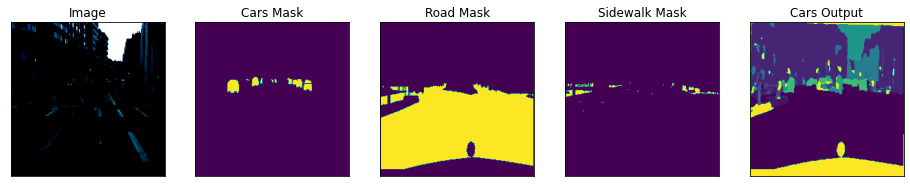

'\n\nvisualize(\n    image=image.data.numpy().transpose(1,2,0), \n    gen_mask=mask.data.numpy().transpose(1,2,0)[..., 0],\n    Pred_mask=output.transpose(1,2,0)[..., 0],\n)\n'

In [ ]:

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('car')],
    road_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('road')],
    sidewalk_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('sidewalk')],
    cars_Output=output.transpose(1,2,0)[:,:,0],
    #road_Output=output.transpose(1,2,0)[:,:,CLASSES.index('road')],
    #sidewalk_Output=output.transpose(1,2,0)[:,:,CLASSES.index('sidewalk')],
)
'''

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    gen_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Pred_mask=output.transpose(1,2,0)[..., 0],
)
'''

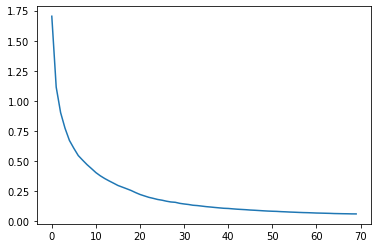

In [ ]:
#loss_logger = torch.load(checkpoint)['loss_logger']
plt.plot(loss_logger)

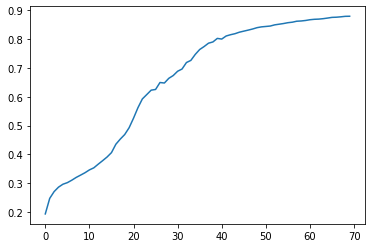

In [ ]:
#Metrics_train_logger = torch.load(checkpoint)['Metrics_train_logger']
plt.plot(Metrics_train_logger)

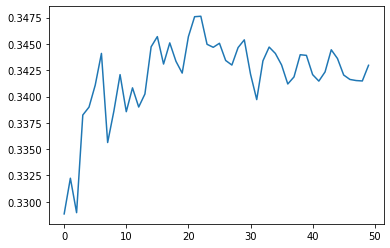

In [ ]:
#Metrics_val_logger = torch.load(checkpoint)['Metrics_val_logger']
plt.plot(Metrics_val_logger)

In [ ]:
# Lets look at augmented data we have
# Lets look at augmented data we have
dataset = CityDataset(x_valid_dir, y_valid_seg_dir, classes=CLASSES,transform=None,preprocessing=get_preprocessing_fn())


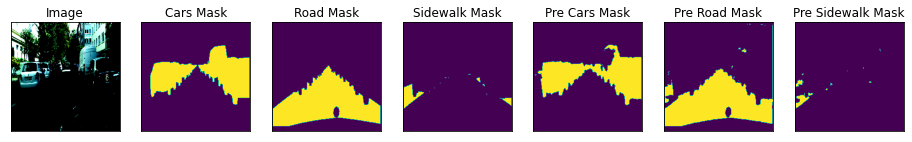

In [ ]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['mask']

model.eval()

with torch.no_grad():
    output = model(image[None,:,:,:].cuda())
    output = get_output(output)

output = (output.cpu().numpy().transpose(1,2,0).squeeze())

Pred_masks = []

for v in range(len(CLASSES)):
    if v == 19:
        Pred_masks.append(( output == 255))
    else :
        Pred_masks.append((output == v))

Pred_mask = np.stack(Pred_masks, axis=-1).astype('float')


visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('car')],
    road_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('road')],
    sidewalk_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('sidewalk')],    
    Pre_cars_mask=Pred_mask[..., CLASSES.index('car')],
    Pre_road_mask=Pred_mask[..., CLASSES.index('road')],
    Pre_sidewalk_mask=Pred_mask[..., CLASSES.index('sidewalk')],
)